In [35]:
import numpy as np
import pandas as pd
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [10]:
seed = 1
file = open("test.txt", "w")
# for a year of weather data
for x in range(0, 365):
    timpeve = random.randint(0, 1)
    impeve = str(timpeve)
    tdecibel = random.randint(60, 70)
    decibel = str(tdecibel)
    halfa = random.randint(0, 23)
    halfb = random.randint(0, 59)
    if halfa == 0:
        if halfb < 10:
            time = "000" + str(halfb)
        else:
            time = "00" + str(halfb)
    else:
        if halfa < 10:
            if halfb < 10:
                time = "0" + str(halfa) + "0" + str(halfb)
            else:
                time = "0" + str(halfa) + str(halfb)

        elif halfb < 10:
            if halfa < 10:
                time = "0" + str(halfa) + "0" + str(halfb)
            else:
                time = str(halfa) + "0" + str(halfb)
        else:
            time = str(halfa) + str(halfb)
    tfail = random.randint(0, 1)
    fail = str(tfail)
    tanomaly = random.randint(0, 1)
    anomaly = str(tanomaly)
    file.write(impeve + " " + decibel + " " + fail + " " + time + " " + anomaly + "\n")
    random.seed()
file.close()

In [11]:
relevantWeatherData = pd.read_csv('888.csv');
relevantWeatherData = relevantWeatherData.drop(['WT01', 'WT02','WT03','WT04','WT05','WT06','WT08','WT09', 'AWND', 'TAVG', 'STATION', 'STATION_NAME'], axis = 1)
# now we have ['date','prcp', 'snow', 'tmax', and 'tmin' as our features]
# but we want to specify LABC weather data, for this example
# so we make a copy of the original dataframe
# and splice it to only include the weather data from Los Angeles
# these are rows 216 - 581 in our .csv file 
labcWeather = relevantWeatherData[:]

labcWeather = labcWeather[214:580]

# we reset the index of every data value so that it can merge with our pseudo-random dataset
# 2016 was a leap year, so we have 366 entries

labcWeather = labcWeather.reset_index(drop=True)

labcWeather['SNOW'] = labcWeather['SNOW'].replace([-9999.0], 0.0)
print(labcWeather[0:6])

       DATE  PRCP  SNOW  TMAX  TMIN
0  20160101  0.00   0.0    65    44
1  20160102  0.00   0.0    64    47
2  20160103  0.00   0.0    62    45
3  20160104  0.00   0.0    67    56
4  20160105  1.42   0.0    59    52
5  20160106  1.18   0.0    57    47


In [12]:
equipmentData = pd.read_csv('test.txt', sep=" ", header = None, names = ['ImpEvent', 'SigLvl', 'NearbyFail', 'Time', 'Anomaly'])

In [21]:
# x now contains the weather data in conjunction with the equipment data we created
x = pd.merge(left=labcWeather, right=equipmentData,left_index = True, right_index = True)
x[::91]

,DATE,PRCP,SNOW,TMAX,TMIN,ImpEvent,SigLvl,NearbyFail,Time,Anomaly
0,20160101,0.0,0.0,65,44,1,61,0,2156,1
91,20160401,0.0,0.0,67,53,1,61,1,636,1
182,20160701,0.0,0.0,75,66,1,61,1,2049,0
273,20160930,0.0,0.0,80,67,0,68,0,2305,0
364,20161230,0.2,0.0,63,56,0,70,1,1844,1


In [25]:
# we have to normalize the values. 
# in this case, we normalize only the values we're going to use. Rain and Signal Power
prcpMax = x['PRCP'].max()
sigMax = x['SigLvl'].max()
x['NormPRCP'] = x['PRCP'].apply(lambda y: y / prcpMax)
x['NormSIG'] = x['SigLvl'].apply(lambda z: z / sigMax)

In [27]:
x[::90]

,DATE,PRCP,SNOW,TMAX,TMIN,ImpEvent,SigLvl,NearbyFail,Time,Anomaly,NormPRCP,NormSIG
0,20160101,0.0,0.0,65,44,1,61,0,2156,1,0.0,0.871429
90,20160331,0.0,0.0,66,49,1,66,1,1412,1,0.0,0.942857
180,20160629,0.0,0.0,75,65,1,63,1,916,0,0.0,0.900000
270,20160927,0.0,0.0,96,72,0,60,1,2114,0,0.0,0.857143
360,20161226,0.0,0.0,63,46,0,61,0,2209,0,0.0,0.871429


<function matplotlib.pyplot.show>

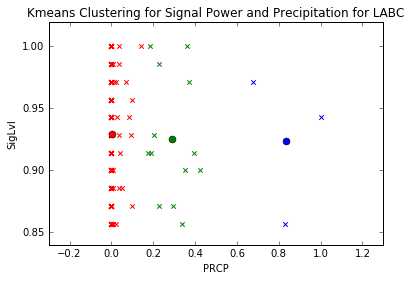

In [48]:
%matplotlib inline
kMeans = KMeans(n_clusters=3)
X = x[['NormPRCP', 'NormSIG']]
kMeans.fit(X)

# Assigned Labels after clustering: 
labels = kMeans.labels_

# Centers of the clusters:
centers = kMeans.cluster_centers_

plt.figure

for l, c in zip([0,1,2], ['red', 'blue', 'green']):
    
    current_members = (labels == l)
    current_center = centers[l]
    
    plt.scatter(X.iloc[current_members,0], X.iloc[current_members,1], color = c, marker='x')
    
    plt.plot(current_center[0], current_center[1], 'o', markerfacecolor = c,
            markeredgecolor = 'k', markersize=7)
    
plt.xlim([-0.3,1.3])

    
plt.xlabel('PRCP')
plt.ylabel('SigLvl')
plt.title('Kmeans Clustering for Signal Power and Precipitation for LABC')

plt.show

In [58]:
# std and mean for NORMALIZED values
# list which features to get std and mean
# for example, it wouldnt make sense to get std and mean of date and time
stdMeanFeats = ['PRCP','SNOW', 'TMAX','TMIN','SigLvl']
print(x[stdMeanFeats].std())
print()
print(x[stdMeanFeats].mean())


PRCP      0.134164
SNOW      0.000000
TMAX      7.482619
TMIN      6.319076
SigLvl    3.145637
dtype: float64

PRCP       0.027945
SNOW       0.000000
TMAX      71.953425
TMIN      57.841096
SigLvl    65.057534
dtype: float64
